# Algoritmos de clustering



# **Datos nutricionales del menú de Burger King**
Este conjunto de datos es una recopilación completa de información nutricional de los principales elementos del menú que ofrece Burger King. El conjunto de datos incluye información sobre la cantidad de calorías, grasas totales, grasas saturadas, grasas trans, colesterol, sodio, carbohidratos totales y proteínas que se encuentran en cada elemento del menú.

Esta información permite a las personas tomar decisiones informadas sobre su ingesta dietética y les ayuda a gestionar mejor su salud y bienestar.

https://www.kaggle.com/datasets/mattop/burger-king-menu-nutrition-data/data

In [ ]:
!pip install dask_ml

In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from dask_ml.cluster import KMeans
import dask.array as da
from pyspark.sql import SparkSession
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import time

# Cargar datos
data = pd.read_csv('/content/burger-king-menu.csv')



In [4]:
data.head()

,Item,Category,Calories,Fat Calories,Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g),Weight Watchers
0,Whopper® Sandwich,Burgers,660.0,360.0,40.0,12.0,1.5,90.0,980.0,49.0,2.0,11.0,28.0,655.0
1,Whopper® Sandwich with Cheese,Burgers,740.0,420.0,46.0,16.0,2.0,115.0,1340.0,50.0,2.0,11.0,32.0,735.0
2,Bacon & Cheese Whopper® Sandwich,Burgers,790.0,460.0,51.0,17.0,2.0,125.0,1560.0,50.0,2.0,11.0,35.0,783.0
3,Double Whopper® Sandwich,Burgers,900.0,520.0,58.0,20.0,3.0,175.0,1050.0,49.0,2.0,11.0,48.0,883.0
4,Double Whopper® Sandwich with Cheese,Burgers,980.0,580.0,64.0,24.0,3.0,195.0,1410.0,50.0,2.0,11.0,52.0,963.0


In [5]:
#Preprocesamiento
data.isnull().sum()

Item                 0
Category             0
Calories             0
Fat Calories         0
Fat (g)              0
Saturated Fat (g)    0
Trans Fat (g)        0
Cholesterol (mg)     0
Sodium (mg)          0
Total Carb (g)       0
Dietary Fiber (g)    0
Sugars (g)           0
Protein (g)          0
Weight Watchers      0
dtype: int64

In [6]:
data.describe()

,Calories,Fat Calories,Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g),Weight Watchers
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,501.428571,278.311688,30.967532,9.805195,0.636364,101.753247,993.246753,35.181818,1.779221,6.636364,20.909091,497.064935
std,307.612685,184.393762,20.535966,8.118431,1.128682,97.958659,613.426403,20.716588,1.690713,6.973463,17.145033,302.238070
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,12.000000
25%,260.000000,140.000000,16.000000,3.500000,0.000000,25.000000,470.000000,26.000000,1.000000,1.000000,12.000000,252.000000
50%,430.000000,250.000000,28.000000,8.000000,0.000000,70.000000,1010.000000,30.000000,1.000000,6.000000,17.000000,416.000000
75%,700.000000,380.000000,42.000000,14.000000,0.500000,175.000000,1420.000000,49.000000,2.000000,10.000000,28.000000,690.000000
max,1220.000000,750.000000,84.000000,33.000000,4.500000,390.000000,2840.000000,110.000000,9.000000,40.000000,71.000000,1192.000000


In [28]:
data.columns

Index(['Item', 'Category', 'Calories', 'Fat Calories', 'Fat (g)',
       'Saturated Fat (g)', 'Trans Fat (g)', 'Cholesterol (mg)', 'Sodium (mg)',
       'Total Carb (g)', 'Dietary Fiber (g)', 'Sugars (g)', 'Protein (g)',
       'Weight Watchers', 'cluster'],
      dtype='object')

In [29]:
#Seleccione las columnas de Grasas totales y total de carbohidratos .
X =  data.iloc[:, [4, 9]].values
X[0:5]


array([[40., 49.],
       [46., 50.],
       [51., 50.],
       [58., 49.],
       [64., 50.]])

In [32]:
#Estandarización de datos
X_s = StandardScaler()
X_std=X_s.fit_transform(X)
X_std[0:5]

array([[0.44272071, 0.67138438],
       [0.73680693, 0.71997141],
       [0.98187878, 0.71997141],
       [1.32497937, 0.67138438],
       [1.61906559, 0.71997141]])

## **Algoritmo K-means**

# **Con Dask**

In [10]:
#Convertir a Dask array
X_std_dask = da.from_array(X_std,chunks=(1000,2))

In [12]:
import psutil
#K-means con Dask-ML
kmeans = KMeans(n_clusters=5,init='k-means||',max_iter=300,n_init=10,random_state=0)

#Medir el tiempo de ejecución
start_time1 = time.time()

kmeans.fit(X_std_dask)

# Calcular el tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time1
print("Tiempo de ejecución en Dask: {:.2f} segundos".format(execution_time))

# Uso de recursos
print(f'CPU usage: {psutil.cpu_percent()}%')
print(f'Memory usage: {psutil.virtual_memory().percent}%')

Tiempo de ejecución en Dask: 0.54 segundos
CPU usage: 54.8%
Memory usage: 13.1%


In [13]:
#Predicciones de los clusters
y_kmeans=kmeans.predict(X_std_dask).compute()
y_kmeans

array([2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 2, 4, 4, 0, 0, 2, 0, 0,
       2, 2, 2, 2, 2, 0, 0, 4, 4, 0, 2, 4, 4, 0, 1, 4, 4, 2, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 4, 2, 2, 4,
       0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [14]:
#Obtener los centroides estandarizados
centroides_estandarizados=kmeans.cluster_centers_

In [15]:
centroides_estandarizados

array([[-0.19020399, -0.24331922],
       [ 2.16522572,  0.74079442],
       [ 0.58042775,  0.85879148],
       [ 0.68779256,  3.27079035],
       [-1.01443567, -1.00689253]])

In [16]:
#Añadir la información de los clusters a los datos originales
data['cluster']=y_kmeans
data.head()

,Item,Category,Calories,Fat Calories,Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g),Weight Watchers,cluster
0,Whopper® Sandwich,Burgers,660.0,360.0,40.0,12.0,1.5,90.0,980.0,49.0,2.0,11.0,28.0,655.0,2
1,Whopper® Sandwich with Cheese,Burgers,740.0,420.0,46.0,16.0,2.0,115.0,1340.0,50.0,2.0,11.0,32.0,735.0,2
2,Bacon & Cheese Whopper® Sandwich,Burgers,790.0,460.0,51.0,17.0,2.0,125.0,1560.0,50.0,2.0,11.0,35.0,783.0,2
3,Double Whopper® Sandwich,Burgers,900.0,520.0,58.0,20.0,3.0,175.0,1050.0,49.0,2.0,11.0,48.0,883.0,2
4,Double Whopper® Sandwich with Cheese,Burgers,980.0,580.0,64.0,24.0,3.0,195.0,1410.0,50.0,2.0,11.0,52.0,963.0,1


In [17]:
# Transformación inversa de los centroides para obtener los valores originales
centroides_originales = X_s.inverse_transform(centroides_estandarizados)

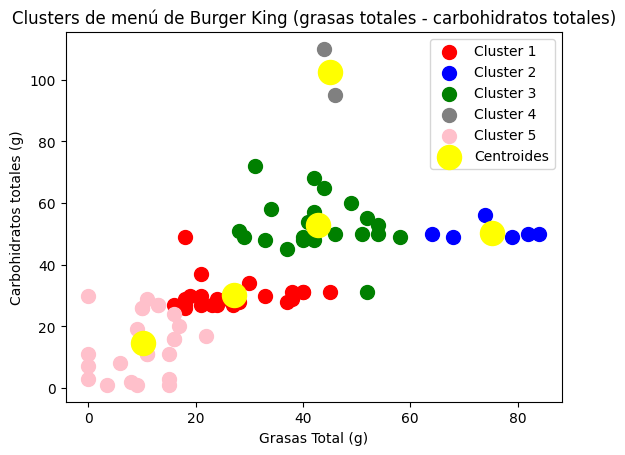

In [18]:
# Visualizando los clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=100, c='green', label='Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s=100, c='gray', label='Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s=100, c='pink', label='Cluster 5')
# Traza el centroide
plt.scatter(centroides_originales[:, 0], centroides_originales[:, 1], s=300, c='yellow', label='Centroides')
plt.title('Clusters de menú de Burger King (grasas totales - carbohidratos totales)')
plt.xlabel('Grasas Total (g)')
plt.ylabel('Carbohidratos totales (g)')
plt.legend()
plt.show()

### **Métrica Silhouette Score**
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

Calcule el coeficiente de silueta medio de todas las muestras.

In [19]:
silhouette_score(X_std_dask, y_kmeans)

0.42543368368174217

### **Métrica  Davies-Bouldin Index**

Es una métrica de validación que se utiliza para evaluar modelos de agrupación.

https://www.geeksforgeeks.org/davies-bouldin-index/

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X_std_dask, y_kmeans)

0.6569043750286175

# **Con Pyspark**

In [20]:
#Iniciar el servidor PySpark
spark = SparkSession.builder.appName('cluster').getOrCreate()
print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.1


In [21]:
#Cargar los datos
dataset = spark.read.csv("/content/burger-king-menu.csv",header=True,inferSchema=True)

#show permite mostrar los datos del archivo
dataset.show(5)

+--------------------+--------+--------+------------+-------+-----------------+-------------+----------------+-----------+--------------+-----------------+----------+-----------+---------------+
|                Item|Category|Calories|Fat Calories|Fat (g)|Saturated Fat (g)|Trans Fat (g)|Cholesterol (mg)|Sodium (mg)|Total Carb (g)|Dietary Fiber (g)|Sugars (g)|Protein (g)|Weight Watchers|
+--------------------+--------+--------+------------+-------+-----------------+-------------+----------------+-----------+--------------+-----------------+----------+-----------+---------------+
|   Whopper® Sandwich| Burgers|   660.0|       360.0|   40.0|             12.0|          1.5|            90.0|      980.0|          49.0|              2.0|      11.0|       28.0|          655.0|
|Whopper® Sandwich...| Burgers|   740.0|       420.0|   46.0|             16.0|          2.0|           115.0|     1340.0|          50.0|              2.0|      11.0|       32.0|          735.0|
|Bacon & Cheese Wh...| Bu

In [22]:
# VectorAssembler para convertir las columnas de características en un solo vector
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols = ['Fat (g)', 'Total Carb (g)'],
                                outputCol='Caracteristicas')

data_final = vec_assembler.transform(dataset)
data_final.select('Caracteristicas').show(5)

+---------------+
|Caracteristicas|
+---------------+
|    [40.0,49.0]|
|    [46.0,50.0]|
|    [51.0,50.0]|
|    [58.0,49.0]|
|    [64.0,50.0]|
+---------------+
only showing top 5 rows



In [23]:
from pyspark.ml.feature import StandardScaler
X_s = StandardScaler()
scaler = StandardScaler(inputCol='Caracteristicas', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(data_final)
scaled_data = scaler_model.transform(data_final)
scaled_data.select('scaled_features').show(5)

+--------------------+
|     scaled_features|
+--------------------+
|[0.43983650279356...|
|[0.73200683247096...|
|[0.97548210720212...|
|[1.31634749182575...|
|[1.60851782150314...|
+--------------------+
only showing top 5 rows



In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
# Medir el tiempo de ejecución
start_time2 = time.time()


# Configurar el modelo KMeans en PySpark
kmeans1 = KMeans(featuresCol='scaled_features',k=5, initMode='k-means||',maxIter=300,seed=0)
# Entrenar el modelo KMeans
model = kmeans1.fit(scaled_data)

# Calcular el tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time2

print("Tiempo de ejecución en PySpark: {:.2f} segundos".format(execution_time))

# Uso de recursos
print(f'CPU usage: {psutil.cpu_percent()}%')
print(f'Memory usage: {psutil.virtual_memory().percent}%')

# Obtener predicciones
predictions = model.transform(scaled_data)

Tiempo de ejecución en PySpark: 6.94 segundos
CPU usage: 14.8%
Memory usage: 18.4%


In [25]:
#Imprimir los centros
centroides = model.clusterCenters()
print("Cluster Centros: ")
for center in centroides:
    print(center)

Cluster Centros: 
[-1.12855006 -1.41666593]
[0.54209612 1.1738507 ]
[2.04677332 0.72734861]
[ 0.34244639 -0.16675262]
[-0.67078533 -0.40236665]


In [26]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         2|
|         2|
+----------+
only showing top 5 rows



### **Métrica Silhouette Score**
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.ClusteringEvaluator.html

Calcule el coeficiente de silueta medio de todas las muestras.

In [27]:
evaluacion = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaled_features',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')
score=evaluacion.evaluate(predictions)
score

0.5398231679067336

# **Con sklearn**

In [34]:
# Clase KMeans de la biblioteca sklearn.
from sklearn.cluster import KMeans
#En lugar de seleccionar los centroides iniciales de forma aleatoria, "k-means++"
#utiliza un enfoque más sofisticado basado en una distribución de probabilidad.
# n_init=10 :Número de veces que se ejecuta el algoritmo k-means con diferentes semillas de centroide.
import time


kmeans = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=10, random_state=0 )
# Medir el tiempo de ejecución
start_time0 = time.time()

#Entrenar el modelo
y_kmeans = kmeans.fit_predict(X_std)

# Calcular el tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time0

print("Tiempo de ejecución: {:.2f} segundos".format(execution_time))

# Uso de recursos
print(f'CPU usage: {psutil.cpu_percent()}%')
print(f'Memory usage: {psutil.virtual_memory().percent}%')

Tiempo de ejecución: 0.02 segundos
CPU usage: 25.8%
Memory usage: 18.8%


In [35]:
silhouette_score(X_std, y_kmeans)

0.4547101203631183

In [36]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X_std, y_kmeans)

0.607111020536463